In [1]:
#7_PAH_zf_morphology
import sys
util_path = "/Users/kimd999/Dropbox/script/python/srpAnalytics/analysis/latest/3_bmd_feasibility_BMD/common/util"
sys.path.insert(0, util_path)

import numpy as np
import pandas as pd
import os, sys, time
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

import BMD_BMDL_estimation as bmdest
import generate_dose_response_newest_no_avg as gdr
import Plot_Save as ps

import warnings
warnings.filterwarnings('ignore')

In [2]:
starting_dir = os.getcwd()
print (starting_dir)

/Users/kimd999/Dropbox/script/python/srpAnalytics/analysis/latest/3_bmd_feasibility_BMD/7_PAH_zf_morphology


In [3]:
complete_file_path = '/Users/kimd999/research/projects/toxicity/per_each_data/7_PAH_zf_morphology/input/wide/7_PAH_zf_morphology_data_2020NOV11_wide_DNC_0.csv'

morphological_data = pd.read_csv(complete_file_path, header = 0)
pd.set_option('display.max_columns', None)
display(morphological_data.head())
display(morphological_data.columns)
display(np.unique(morphological_data.well))

,chemical.id,plate.id,well,chemical_plate_well,conc,AXIS,BRN_,CRAN,DNC_,DP24,EDEM,LTRK,MO24,MORT,MUSC,NC__,SKIN,SM24,TCHR
0,3756,20544,A01,3756_20544_A01,100.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,3756,20544,A02,3756_20544_A02,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3756,20544,A03,3756_20544_A03,100.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,3756,20544,A04,3756_20544_A04,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3756,20544,A05,3756_20544_A05,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Index(['chemical.id', 'plate.id', 'well', 'chemical_plate_well', 'conc',
       'AXIS', 'BRN_', 'CRAN', 'DNC_', 'DP24', 'EDEM', 'LTRK', 'MO24', 'MORT',
       'MUSC', 'NC__', 'SKIN', 'SM24', 'TCHR'],
      dtype='object')

array(['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09',
       'A10', 'A11', 'A12', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06',
       'B07', 'B08', 'B09', 'B10', 'B11', 'B12', 'C01', 'C02', 'C03',
       'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12',
       'D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09',
       'D10', 'D11', 'D12', 'E01', 'E02', 'E03', 'E04', 'E05', 'E06',
       'E07', 'E08', 'E09', 'E10', 'E11', 'E12', 'F01', 'F02', 'F03',
       'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12',
       'G01', 'G02', 'G03', 'G04', 'G05', 'G06', 'G07', 'G08', 'G09',
       'G10', 'G11', 'G12', 'H01', 'H02', 'H03', 'H04', 'H05', 'H06',
       'H07', 'H08', 'H09', 'H10', 'H11', 'H12'], dtype=object)

In [4]:
#np.sum(morphological_data['MO24'] == 1)

In [5]:
test_data_sim = 0
if(test_data_sim == 0):
    # Add aggregate endpoints
    # 1. Any effect at 24hrs (combination of MO24, DP24 and SM24) >> 'ANY24'
    morphological_data['ANY24'] = morphological_data[['MO24','DP24','SM24']].sum(axis=1,skipna=True,min_count=1)
    
    # 2. Any effect within 5 days (combination of all measurements at both time points)
    morphological_data['ANY120'] = morphological_data[['AXIS', 'BRN_', 'CRAN', 'EDEM', 'LTRK', 'MORT', 'MUSC', 'NC__', 'SKIN', 'TCHR', 'ANY24']].sum(axis=1,skipna=True,min_count=1)
    
    # 3. Total mortality (MO24 + MORT) >> 'TOT_MORT'
    morphological_data['TOT_MORT'] = morphological_data[['MO24','MORT']].sum(axis=1,skipna=True,min_count=1)

    # 4. Any effect except mortality (#2 minus MO24 and MORT) >> 'ALL_BUT_MORT'
    morphological_data['ALL_BUT_MORT'] = morphological_data[['AXIS', 'BRN_', 'CRAN', 'DP24', 'EDEM', \
                                                             'LTRK', 'MUSC', 'NC__', 'SKIN', 'SM24', 'TCHR']].sum(axis=1,skipna=True,min_count=1)


In [6]:
# morphological_data_end_point_chemical_id = morphological_data.loc[morphological_data['chemical.id'] == chemical_id,['chemical.id', 'conc', 'plate.id', 'well', end_point]]
morphological_data_end_point_chemical_id = morphological_data.loc[morphological_data['chemical.id'] == 1532,['chemical.id', 'conc', 'plate.id', 'well', 'ANY24']]
display(morphological_data_end_point_chemical_id)
#display(morphological_data.loc[morphological_data[]'chemical.id']==1532)
#print ("done")

,chemical.id,conc,plate.id,well,ANY24


In [7]:
display(morphological_data.head())

,chemical.id,plate.id,well,chemical_plate_well,conc,AXIS,BRN_,CRAN,DNC_,DP24,EDEM,LTRK,MO24,MORT,MUSC,NC__,SKIN,SM24,TCHR,ANY24,ANY120,TOT_MORT,ALL_BUT_MORT
0,3756,20544,A01,3756_20544_A01,100.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN
1,3756,20544,A02,3756_20544_A02,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3756,20544,A03,3756_20544_A03,100.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN
3,3756,20544,A04,3756_20544_A04,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3756,20544,A05,3756_20544_A05,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
if (os.path.isdir("output") == False):
    os.mkdir("output")

output_folder = os.path.join(starting_dir, "output")
os.chdir(output_folder)
    
if (os.path.isdir("report") == False):
    os.mkdir("report")
    
morphological_data_filename = os.path.join("report", 'morphological_data.csv')
morphological_data_file_out = open(morphological_data_filename, "w")
morphological_data.to_csv(morphological_data_filename, index=False)
morphological_data_file_out.close()

In [9]:
# Specify end_point and chemical of interest
# Perform a check of the existence of "essential" column labels

start_time = time.time()

qc_flag_filename = os.path.join("report", 'qc_flag.csv')
qc_flag_file_out = open(qc_flag_filename, "w")

write_this = "qc_flag\n"
qc_flag_file_out.write(write_this)

erased_morphological_data_end_point_chemical_id_filename = os.path.join("report", 'erased_morphological_data_end_point_chemical_id.csv')
erased_morphological_data_end_point_chemical_id_file = open(erased_morphological_data_end_point_chemical_id_filename, "w")
write_this="chemical_id,plate_id,end_point\n"
erased_morphological_data_end_point_chemical_id_file.write(write_this)
erased_morphological_data_end_point_chemical_id_file.close()


erased_morphological_data_end_point_chemical_id_filename_0p25_erased = erased_morphological_data_end_point_chemical_id_filename[:-4] + '_0p25_erased.csv'
erased_morphological_data_end_point_chemical_id_file_0p25_erased = open(erased_morphological_data_end_point_chemical_id_filename_0p25_erased, "w")
write_this="chemical_id,end_point,dose\n"
erased_morphological_data_end_point_chemical_id_file_0p25_erased.write(write_this)
erased_morphological_data_end_point_chemical_id_file_0p25_erased.close()


erased_morphological_data_end_point_chemical_id_filename_0p25_kept = erased_morphological_data_end_point_chemical_id_filename[:-4] + '_0p25_kept.csv'
erased_morphological_data_end_point_chemical_id_file_0p25_kept = open(erased_morphological_data_end_point_chemical_id_filename_0p25_kept, "w")
write_this="chemical_id,end_point,dose\n"
erased_morphological_data_end_point_chemical_id_file_0p25_kept.write(write_this)
erased_morphological_data_end_point_chemical_id_file_0p25_kept.close()

# full -> 17 (without DNC) unlike phase_I_II (18 endpoints), 7_PAH lacks NC24
#end_points = ['ANY24','ANY120','AXIS','ALL_BUT_MORT','BRN_','CRAN','DP24','EDEM','LTRK','MO24','MORT','MUSC','NC__', 'SKIN','SM24','TCHR','TOT_MORT']
end_points = ['ANY24','CRAN']

# all chemicals
#for chemical_id in np.unique(morphological_data['chemical.id']):
    
for chemical_id in [66]:
    print("chemical_id:" + str(chemical_id))

    for end_point in end_points:
        os.chdir(output_folder)
        # subset original dataframe for a user-specified chemical and end_point pair
        morphological_data_end_point_chemical_id = morphological_data.loc[morphological_data['chemical.id'] == chemical_id,['chemical.id', 'conc', 'plate.id', 'well', end_point]]
        
        # Binarize end-point hits (Values > 1 are forced to 1)
        end_point_hits = morphological_data_end_point_chemical_id[end_point]
        end_point_hits.loc[end_point_hits > 0] = 1
        
        #print (str(morphological_data_end_point_chemical_id))
   #     morphological_data_end_point_chemical_id.to_csv('morpho.csv', index=False)

#        f_end_point = open('end_point.txt', 'w')
 #       f_end_point.write(str(end_point))
  #      f_end_point.close()
                  
        dose_response = gdr.gen_dose_response(morphological_data_end_point_chemical_id, end_point)
        
        qc_flag = gdr.BMD_feasibility_analysis(dose_response)
    #    qc_flag = gdr.BMD_feasibility_analysis_qc_1(dose_response)
        qc_flag_file_out.write(str(qc_flag)+"\n")
        
        test_dose_response = gdr.reformat_dose_response(dose_response)
        
#        write_this = str(chemical_id) + "," + str(end_point) + "," + str(len(test_dose_response)) + "\n"
 #       print ("write_this:"+str(write_this))
  #      f_out.write(write_this)
    
        #qc_flag_folder = "qc_" + str(qc_flag)
        #if (os.path.isdir(str(qc_flag_folder)) == False):
        #    os.mkdir(str(qc_flag_folder))
        #os.chdir(str(qc_flag_folder))

        if(qc_flag in [0, 1]):
            # No BMD analysis required. Generate report and exit
            ps.save_results_poor_data_or_no_convergence(test_dose_response, qc_flag, str(chemical_id), end_point, None)
        else:
            # Fit dose response models
            model_predictions = bmdest.analyze_dose_response_data(test_dose_response)
            # Select best model
            selected_model_params = bmdest.select_model(model_predictions)
            # Check if unique model is found
            unique_model_flag = selected_model_params['no_unique_model_found_flag']
            if(unique_model_flag == 0):
                # Generate report
                print(test_dose_response.dose[-1:])
                ps.save_results_good_data_unique_model(test_dose_response, qc_flag, model_predictions, selected_model_params, str(chemical_id), end_point)
            else:
                bmd_analysis_flag = selected_model_params['model_select_flag']
                if(bmd_analysis_flag == 1):
                    ps.save_results_poor_data_or_no_convergence(test_dose_response, qc_flag, str(chemical_id), end_point, selected_model_params)
                else:
                    ps.save_results_good_data_nounique_model(test_dose_response, qc_flag, model_predictions, selected_model_params, str(chemical_id), end_point)
#test_dose_f_out.close()
#f_out.close()
qc_flag_file_out.close()
end_time = time.time()
time_took = str(round((end_time-start_time), 1)) + " seconds"
print ("Done, it took:"+str(time_took)) 
# for all combinations of 342 chemicals and 18 endpoints, 4 minutes took for qc only
# for all combinations of 342 chemicals and 18 endpoints, 104~165 minutes took for qc and bmd report

os.chdir(output_folder)
      
time_filename = os.path.join("report", 'running_time.txt')
f_time = open(time_filename, 'w')
f_time.write(str(time_took))
f_time.close()

chemical_id:66
data_ep_cid:
Empty DataFrame
Columns: [chemical.id, conc, plate.id, well, ANY24]
Index: []
dose_response (after dropna):
Empty DataFrame
Columns: [dose, num_affect, frac_affect, num_embryos, tot_wells]
Index: []
data_ep_cid:
Empty DataFrame
Columns: [chemical.id, conc, plate.id, well, CRAN]
Index: []
dose_response (after dropna):
Empty DataFrame
Columns: [dose, num_affect, frac_affect, num_embryos, tot_wells]
Index: []
Done, it took:0.3 seconds


In [10]:
#print (morphological_data_end_point_chemical_id)
np.asarray(morphological_data_end_point_chemical_id['plate.id'])

array([], dtype=int64)

In [11]:
#[np.unique(morphological_data_end_point_chemical_id['chemical.id'].values()),1]

qc_flag_filename:report/qc_flag.csv


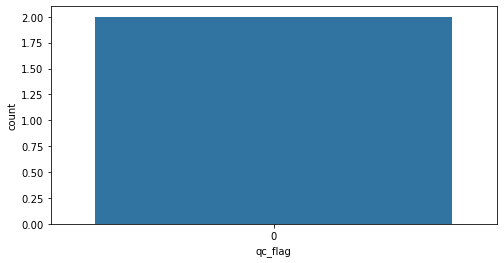

In [12]:
os.chdir(output_folder)

qc_flag_filename = os.path.join("report", 'qc_flag.csv')
print ("qc_flag_filename:"+str(qc_flag_filename))
qc_flag_data = pd.read_csv(qc_flag_filename, index_col=None)
#display(qc_flag_data.head())
ds = pd.Series({"Column": qc_flag_data["qc_flag"]})
plt.figure(figsize=(8,4))
sns.countplot(x="Column", data=ds)
plt.show()

In [13]:
'''os.chdir(starting_dir)

sns.set_theme(style="whitegrid")
print ("array_filename:"+str(array_filename))
array_report_data = pd.read_csv(array_filename, index_col=None)
display(array_report_data.head())
#ax = sns.barplot(x="end_point", y="len_test_dose_response", data=array_report_data)

ds = pd.Series({"Column": array_report_data["len_test_dose_response"]})
plt.figure(figsize=(8,4))
plt.xlabel("leng")
sns.countplot(x="Column", data=ds)
plt.show()
print ("done")'''

'os.chdir(starting_dir)\n\nsns.set_theme(style="whitegrid")\nprint ("array_filename:"+str(array_filename))\narray_report_data = pd.read_csv(array_filename, index_col=None)\ndisplay(array_report_data.head())\n#ax = sns.barplot(x="end_point", y="len_test_dose_response", data=array_report_data)\n\nds = pd.Series({"Column": array_report_data["len_test_dose_response"]})\nplt.figure(figsize=(8,4))\nplt.xlabel("leng")\nsns.countplot(x="Column", data=ds)\nplt.show()\nprint ("done")'

In [14]:
test_dose_response.dose

Series([], Name: dose, dtype: object)

In [15]:
#test_dose_response.dose.iloc[0]+test_dose_response.dose.iloc[1]

In [16]:
dose_response['num_affect']/dose_response['num_embryos']

Series([], dtype: object)